In [15]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss

# preprocessing imports
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [16]:
df = pd.read_csv("full_data.csv")[["Layout","Powder","PlateID", "Location", "scrap"]]

In [17]:
#Adding combination variables to the dataframe
df['Layout_Powder_Combo'] = df['Layout'] + '_' + df['Powder']
df['Layout_PlateID_Combo'] = df['Layout'] + '_' + df['PlateID']
df['Location_PlateID_Combo'] = df['Location'] + '_' + df['PlateID']
df['Location_Powder_Combo'] = df['Location'] + '_' + df['Powder']
df['Location_Powder_Combo'] = df['Location'] + '_' + df['Powder']
df['PlateID_Powder_Combo'] = df['PlateID'] + '_' + df['Powder']

df.head(3)

,Layout,Powder,PlateID,Location,scrap,Layout_Powder_Combo,Layout_PlateID_Combo,Location_PlateID_Combo,Location_Powder_Combo,PlateID_Powder_Combo
0,6X6,Virgin,A,a1,0,6X6_Virgin,6X6_A,a1_A,a1_Virgin,A_Virgin
1,6X6,Virgin,A,a3,0,6X6_Virgin,6X6_A,a3_A,a3_Virgin,A_Virgin
2,6X6,Virgin,A,a5,0,6X6_Virgin,6X6_A,a5_A,a5_Virgin,A_Virgin


In [18]:
#Splitting original data into train/test
df_train, df_test = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df['scrap']
)

In [19]:
#Seperating x and y columns
X_train = df_train.drop("scrap", axis=1)
y_train = df_train["scrap"]

X_test = df_test.drop("scrap", axis=1)
y_test = df_test["scrap"]

In [20]:
# preprocessing the categorical features 
categorical_features = ["Layout","Powder","PlateID", "Location","Layout_Powder_Combo","Layout_PlateID_Combo","Location_Powder_Combo","PlateID_Powder_Combo"]
features = categorical_features
target = "scrap"

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown = "ignore"),
)

preprocessor = make_column_transformer(
    (categorical_transformer, categorical_features),
    remainder="drop",
)

In [21]:
#Defining calibration error
def calibration_error(y_true, y_prob, type="expected", n_bins=10):
    """
    Compute calibration error of a binary classifier.

    The calibration error measures the aggregated difference between
    the average predicted probabilities assigned to the positive class,
    and the frequencies of the positive class in the actual outcome.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True targets of a binary classification task.

    y_prob : array-like of (n_samples,)
        Estimated probabilities for the positive class.

    type : {'expected', 'max'}, default='expected'
        The expected-type is the Expected Calibration Error (ECE), and the
        max-type corresponds to Maximum Calibration Error (MCE).

    n_bins : int, default=10
       The number of bins used when computing the error.

    Returns
    -------
    score : float
        The calibration error.
    """

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_idx = np.searchsorted(bins[1:-1], y_prob)

    bin_sums = np.bincount(bin_idx, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(bin_idx, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(bin_idx, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    if type == "max":
        calibration_error = np.max(np.abs(prob_pred - prob_true))
    elif type == "expected":
        bin_error = np.abs(prob_pred - prob_true) * bin_total[nonzero]
        calibration_error = np.sum(bin_error) / len(y_true)

    return calibration_error

In [22]:
#Creating and fitting the RandomForest model

params_grid = {
    "method": [
        "isotonic",
        "sigmoid",
    ],
    "estimator__max_depth": [5, 10, 15, 25, None],
    "estimator__criterion": ["log_loss", "gini"],
}

mod = make_pipeline(
    preprocessor,
    GridSearchCV(
    CalibratedClassifierCV(
        estimator=RandomForestClassifier(
            n_estimators=25,
            random_state=42,
        ),
    ),
    cv=5,
    param_grid=params_grid,
    n_jobs=-1,
))

mod.fit(X_train,y_train)
y_pred = mod.predict(X_test)
y_pred_proba = mod.predict_proba(X_test)[:, 1]

In [23]:
test_ece = calibration_error(
    y_test,
    y_pred_proba,
    type="expected",
)

test_accuracy = accuracy_score(y_test, y_pred)
test_logloss = log_loss(y_test, y_pred_proba)
test_brier_score = brier_score_loss(y_test, y_pred_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Log Loss: {test_logloss:.4f}")
print(f"Brier Score: {test_brier_score:.4f}")
print(f"Test ECE: {test_ece:.4f}")

Test Accuracy: 0.8109
Log Loss: 0.4770
Brier Score: 0.1486
Test ECE: 0.0408


In [24]:
# function to plot a reliability diagram
def plot_reliability_diagram(y_true, y_prob):

    # generate "data" for reliability diagram
    prob_true, prob_pred = calibration_curve(
        y_true,
        y_prob,
        n_bins=5,
        pos_label=1,
    )

    # create a figure and axis object with a specific size
    fig, ax = plt.subplots(figsize=(6, 6))

    # plot the reliability diagram
    ax.plot(
        prob_pred,
        prob_true,
        "s-",
        label="Learned Classifier",
        color="tab:blue",
    )

    # plot the diagonal "perfect" line
    ax.plot(
        [0, 1],
        [0, 1],
        "--",
        label="Perfect Calibration",
        color="tab:orange",
    )

    # set the plot title and axis labels
    ax.set_xlabel("Predicted: Average Probability")
    ax.set_ylabel("Actual: Proportion of Positives")

    # add a grid
    ax.grid(
        True,
        color="lightgrey",
        linewidth=0.5,
        linestyle=":",
    )

    # fix aspect ratio
    ax.set_aspect("equal")

    # show the legend
    ax.legend()

    # show the plot
    plt.show()

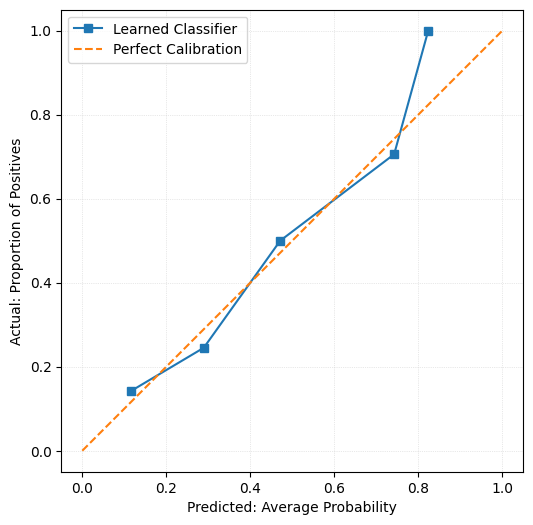

In [25]:
plot_reliability_diagram(y_test, y_pred_proba)


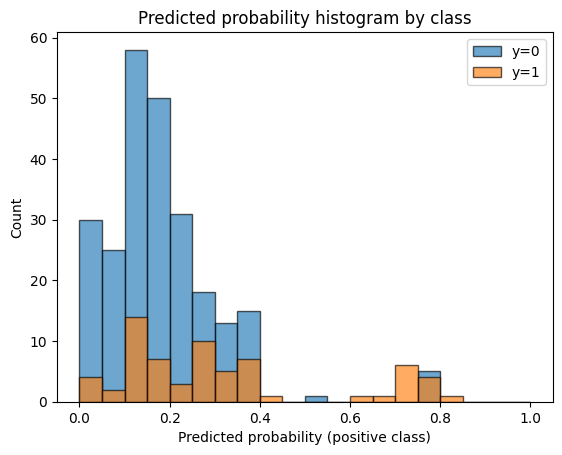

In [26]:
pos = y_pred_proba[y_test == 1]
neg = y_pred_proba[y_test == 0]

plt.figure()
plt.hist(neg, bins=20, range=(0,1), alpha=0.65, edgecolor='k', label="y=0")
plt.hist(pos, bins=20, range=(0,1), alpha=0.65, edgecolor='k', label="y=1")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Count")
plt.title("Predicted probability histogram by class")
plt.legend()
plt.show()

In [27]:
# Create scrap variables
if df['scrap'].dtype == bool:
    df['y_true'] = df['scrap'].astype(int)
elif df['scrap'].dtype == object:  
    df['y_true'] = df['scrap'].map({'good':0, 'scrap':1})
else:  
    df['y_true'] = df['scrap'].astype(int)

# Get predicted probabilities from the model
y_proba_test = mod.predict_proba(X_test)[:, 1]  

df = df.loc[X_test.index].copy()             
df['p_scrap'] = y_proba_test      

In [28]:
#Creating LocationZone variable for improved grouping
def to_zone(loc):
    return ("center" if loc in {"f5","f6","g5","g6","h5","h6","i5","i6"} else
            "inner"  if loc[0] in {"e","f","g","h","i","j"} and 2 <= int(loc[1:]) <= 9 else
            "outer")
df["LocationZone"] = df["Location"].map(to_zone)

#Creating summary table and calculating other metrics like confidence intervals and variance
group_cols = ["Layout","Powder","LocationZone"] 
g = df.groupby(group_cols, dropna=False)
summary = (g.agg(n=('p_scrap','size'),
                 pred_mean=('p_scrap','mean'),
                 obs_rate=('y_true','mean'),
                 pred_var=('p_scrap','var'))
            .reset_index())
summary['pred_var'] = summary['pred_var'].fillna(0.0)
summary['se'] = np.sqrt(summary['pred_var'] / summary['n'].clip(lower=1))
summary['ci_lo'] = np.clip(summary['pred_mean'] - 1.96*summary['se'], 0, 1)
summary['ci_hi'] = np.clip(summary['pred_mean'] + 1.96*summary['se'], 0, 1)

# only keep the configurations with atleast 10 samples
min_n = 10
if (summary['n'] >= min_n).any():
    summary = summary[summary['n'] >= min_n]

summary = summary.sort_values('pred_mean')
print(summary.head(12).to_string(index=False))


 Layout   Powder LocationZone   n  pred_mean  obs_rate  pred_var       se    ci_lo    ci_hi
    6X6   Virgin        outer  11   0.085382  0.181818  0.001718 0.012497 0.060889 0.109876
  6X6TA   Virgin        outer  15   0.100084  0.333333  0.003284 0.014796 0.071085 0.129084
11X11TA   Virgin       center  11   0.116690  0.090909  0.009204 0.028926 0.059995 0.173385
11X11TA   Virgin        inner  31   0.180556  0.096774  0.014442 0.021584 0.138251 0.222861
11X11TA   Virgin        outer  73   0.182312  0.205479  0.013205 0.013450 0.155950 0.208673
11X11TA Recycled        inner  45   0.228186  0.200000  0.040136 0.029865 0.169650 0.286721
11X11TA Recycled        outer 106   0.271078  0.264151  0.034460 0.018030 0.235738 0.306417
11X11TA Recycled       center  11   0.285790  0.272727  0.055010 0.070717 0.147184 0.424395


In [29]:
#How can we interpret this?

# 1. Virgin powder clearly shows a lower pred_mean than recycled.
# 2. If the layout option is flexible, we prefer 6X6 or 6X6TA, with placements specifically in the outer LocationZone. 
# 3. If they use 11X11TA, the center looks the best, and avoid Recycled powder, especially in the outer/center zone.

In [30]:
#Displaying just the metrics of the best configuration
min_n = 10
candidates = summary.query("n >= @min_n").copy()
best_row = candidates.sort_values(["ci_hi","pred_mean"]).iloc[0]
best_config = (best_row.Layout, best_row.Powder, best_row.LocationZone)
best_row[["n","pred_mean","ci_lo","ci_hi","obs_rate"]]


n                  11
pred_mean    0.085382
ci_lo        0.060889
ci_hi        0.109876
obs_rate     0.181818
Name: 7, dtype: object